# Gyakorló feladatok

## 1. feladat
Az alábbi arcérzelem képi adatbázisból vegyük az első 50 képet. Vizualizáljuk ezeket a képeket 2D-ben, úgy, hogy a hasonló képek közelebb vannak egymáshoz!

In [ ]:
# arcérzelem képi adatbázis
import pandas as pd
data = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/images/fer2013_1K.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
995,3,234 168 152 74 33 36 33 33 27 25 33 54 70 80 8...,Training
996,6,130 131 132 132 133 134 134 134 136 138 136 14...,Training
997,3,30 25 19 5 5 4 3 1 1 0 2 26 31 15 10 4 3 3 5 6...,Training
998,0,177 203 157 122 156 178 194 202 199 191 193 17...,Training


In [ ]:
#48x48 szürke képek egy stringbe vannak kódolva, így lesz belőle tömb
import numpy as np
def str2img(img):
  return np.reshape(np.asarray(img.split(' '), np.uint8), (48,48))

In [ ]:
# képeket most csak a pixelekkel írjuk le
features = []
for x in data.pixels.tolist():
  features.append(str2img(x).flatten())

In [ ]:
!wget https://raw.githubusercontent.com/christiansafka/img2vec/master/img2vec_pytorch/img_to_vec.py

--2021-11-22 14:31:12--  https://raw.githubusercontent.com/christiansafka/img2vec/master/img2vec_pytorch/img_to_vec.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6145 (6.0K) [text/plain]
Saving to: ‘img_to_vec.py’

img_to_vec.py       100%[===================>]   6.00K  --.-KB/s    in 0s      

2021-11-22 14:31:13 (69.3 MB/s) - ‘img_to_vec.py’ saved [6145/6145]



In [ ]:
from img_to_vec import Img2Vec
img2vec = Img2Vec()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
from PIL import Image 
img2vec.get_vec(Image.fromarray(image).convert('RGB')) # img2vec csak RGB képeket tud kezelni, a szürkeárnyalatos képeinket RGB-be kell konvertálni!

NameError: ignored

In [ ]:
imgvecs = []
for i in data.pixels:
  imgvec = img2vec.get_vec(Image.fromarray(str2img(i)).convert('RGB'))
  imgvecs.append(imgvec)

In [ ]:
# Az SVD 2 dimenzióba képezi le a képeket
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2) # az első 2 komponenst tartjuk csak meg (2Dbe mappelünk)
p2d = svd.fit_transform(imgvecs)
p2d # minden képhez egy 2D vektor

array([[21.186989  ,  0.69309115],
       [19.54409   , -3.7783966 ],
       [22.926311  ,  4.410363  ],
       ...,
       [18.187777  ,  5.4803386 ],
       [21.174488  ,  1.3911732 ],
       [21.861584  , -1.3471534 ]], dtype=float32)

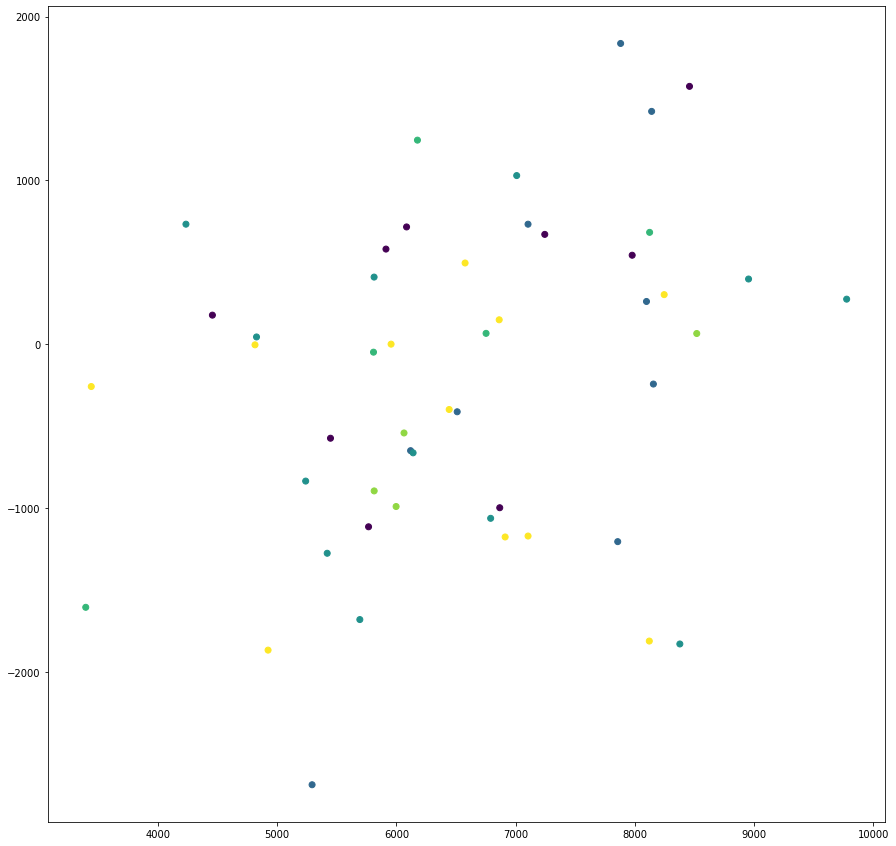

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15)) 
plt.scatter(p2d[:50,0], p2d[:50,1], c=data[:50].emotion) # az első 50 kép SVD koordinátáira kirakunk egy pöttyöt, aminek színe (c=) a kép címkéje

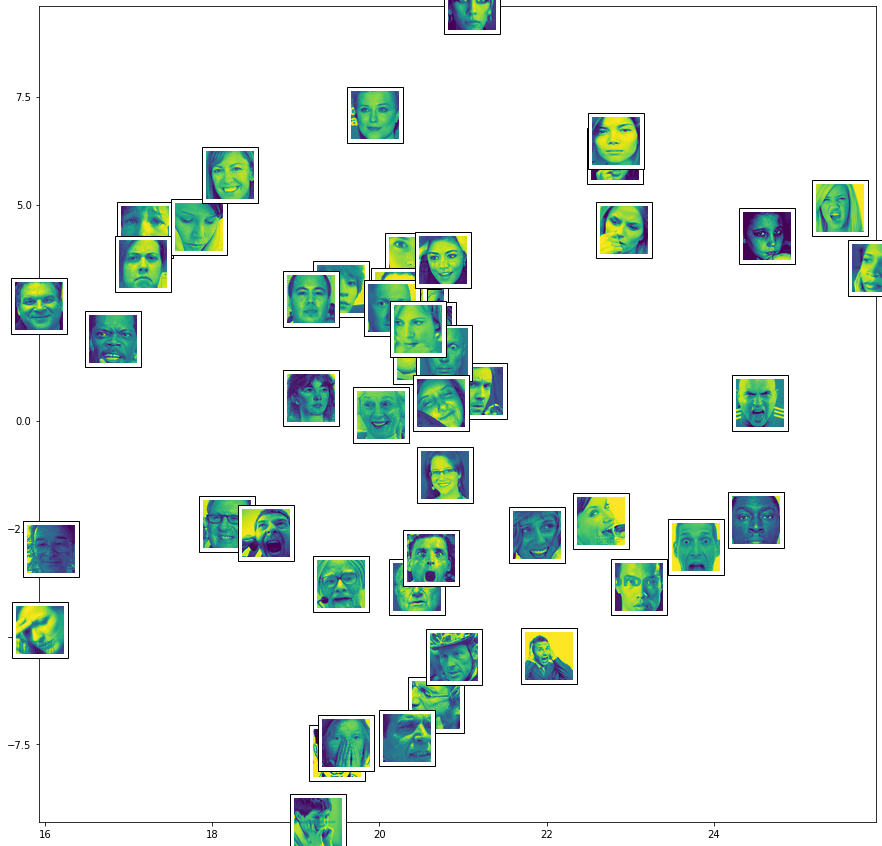

In [ ]:
### bonus feladat: magukat a képeket rajzoljuk ki a pötty helyére
### segített: https://stackoverflow.com/questions/4860417/placing-custom-images-in-a-plot-window-as-custom-data-markers-or-to-annotate-t
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

plt.figure(figsize=(15,15))
ax = plt.subplot(111)

# kép x és y tengelyét állítsuk az SVD min-max értékeire
ax.set(xlim=(min(p2d[:50,0]), max(p2d[:50,0])), ylim=(min(p2d[:50,1]), max(p2d[:50,1])))

for i in range(50):
  img = str2img(data.pixels[i])
  xy = p2d[i]
  ax.add_artist(AnnotationBbox(OffsetImage(img), xy))                                

## 2. feladat

A arcérzelem adatbázist klaszterezzük és minden klaszterből néhány egyedet jelenítsünk meg a 2D térben!

In [ ]:
### K-means kluszterezése az ezer képnek a pixelvektorok alapján (az eredeti térben)
from sklearn.cluster import KMeans
k=5
kmeans = KMeans(n_clusters=k).fit(imgvecs)

In [ ]:
### Összegyűjtjük egy szótárba az egyes klaszterekbe sorolt képek indexeit
cluster = {}
for j in range(k):
  cluster[j] = [i for i, e in enumerate(kmeans.labels_) if e == j] # j. kluszterbe sorolt képek indexei

KeyError: ignored

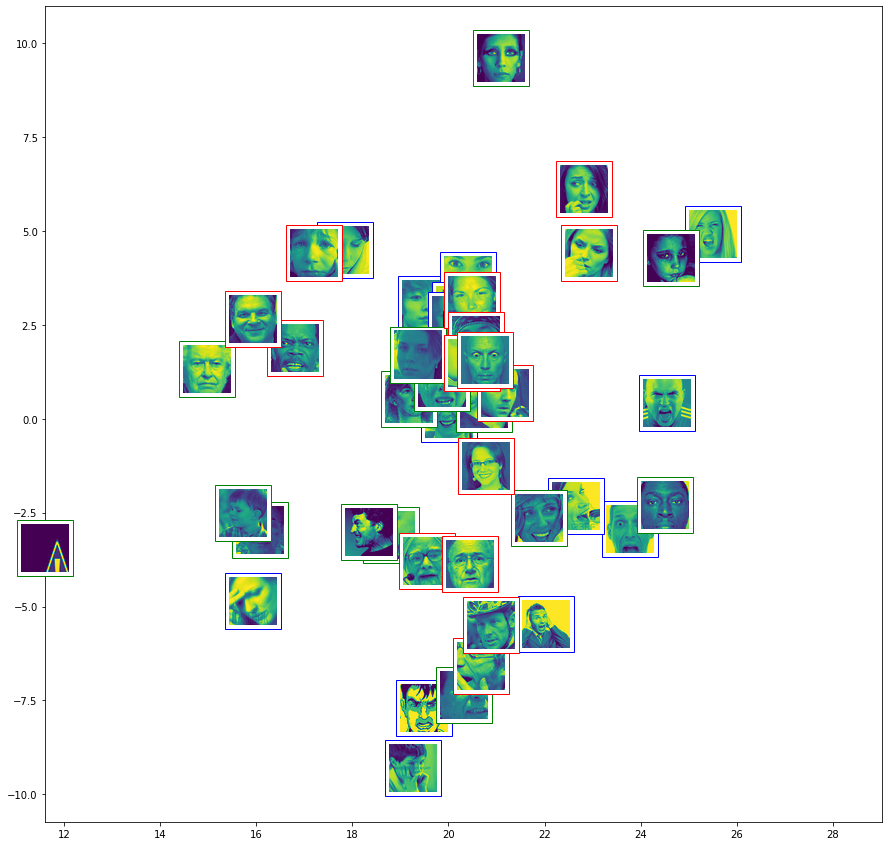

In [ ]:
import matplotlib.colors as mcolors

plt.figure(figsize=(15,15))
ax = plt.subplot(111)
# kép x és y tengelyét állítsuk az ezer kép SVD min-max értékeire
ax.set(xlim=(min(p2d[:,0]), max(p2d[:,0])), ylim=(min(p2d[:,1]), max(p2d[:,1])))

for j in range(k): # minden klaszter
  for i in range(15): # első 5 képét jelenítjük meg
    img = str2img(data.pixels[ cluster[j][i] ]) # cluster[j][i] az index az eredeti adatbázisban
    xy = p2d[ cluster[j][i] ] # 2Dre mappelt koordináták
    ax.add_artist(AnnotationBbox(OffsetImage(img), xy, bboxprops = dict(edgecolor=list(mcolors.BASE_COLORS)[j]))) # a kereteket az egyes klaszterek színére állítjuk